# [IAPR][iapr]: Lab 1 ‒  Image segmentation


**Group ID:** 05

**Author 1 (sciper):** Lavinia Schlyter (284566)
**Author 2 (sciper):** Simon Gilgien (253797)
**Author 3 (sciper):** Cengizhan Bektas (350828)

**Release date:** 11.03.2022
**Due date:** 25.03.2022 (11:59 pm)


## Important notes

The lab assignments are designed to teach practical implementation of the topics presented during class well as
preparation for the final project, which is a practical project which ties together the topics of the course.

As such, in the lab assignments/final project, unless otherwise specified, you may, if you choose, use external
functions from image processing/ML libraries like opencv and sklearn as long as there is sufficient explanation
in the lab report. For example, you do not need to implement your own edge detector, etc.

**! Before handling back the notebook <font color='red'> rerun </font>the notebook from scratch !**
`Kernel` > `Restart & Run All`

We will not rerun the notebook for you.

[iapr]: https://github.com/LTS5/iapr

---
## 0. Extract relevant data
We first need to extract the `lab-01-data.tar.gz` archive.
To this end, we use the [tarfile] module from the Python standard library.

[tarfile]: https://docs.python.org/3.6/library/tarfile.html

In [1]:
import tarfile
import os

data_base_path = os.path.join(os.pardir, 'data')
data_folder = 'lab-01-data'
tar_path = os.path.join(data_base_path, data_folder + '.tar.gz')

if not os.path.exists(tar_path):
    raise Exception('Path to is not valid {}'.format(tar_path))
    
with tarfile.open(tar_path, mode='r:gz') as tar:
    tar.extractall(path=data_base_path)

In [17]:
# Import additional libraries of interest 
import numpy as np
import skimage.io
import matplotlib.pyplot as plt
%matplotlib inline
from skimage import exposure
import cv2
from collections import deque
import matplotlib

---
## Part 1: Brain segmentation

Your goal: compute the size of the brain (without the skull) in pixels in a 2D image of a human head taken by
Magnetic Resonance Imaging (MRI) using:
* Region growing (5 pts)
* Contour detection (5 pts)
* An additional method of your choice (5 pts)

Each section should display the resulting segmentation as well as the size in pixel of the detected region. Comment
each method limitations and/or advantages.

### 1.1 Brain image visualization

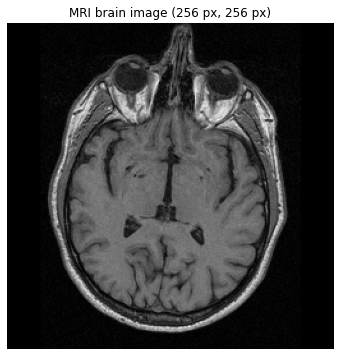

In [18]:
# Load image
data_path = os.path.join(data_base_path, data_folder)
brain_im = skimage.io.imread(os.path.join(data_path, 'brain-slice40.tiff'))
im_h, im_w = brain_im.shape

# Display MRI image
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_im, cmap='gray')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')
plt.show()

### 1.2 Region growing (5pts)

First we plot the histogram of the original image and we normalize it

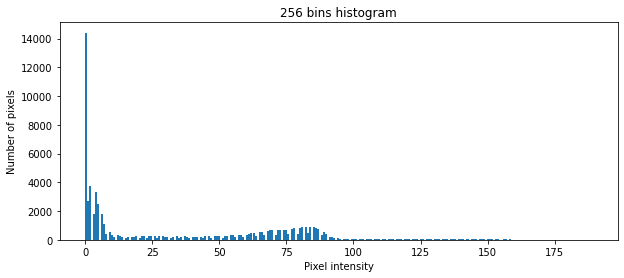

In [19]:
# Plot histogram
plt.figure(figsize=(10, 4))
plt.hist(brain_im.ravel(), bins=256)
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.title('256 bins histogram')

plt.show()

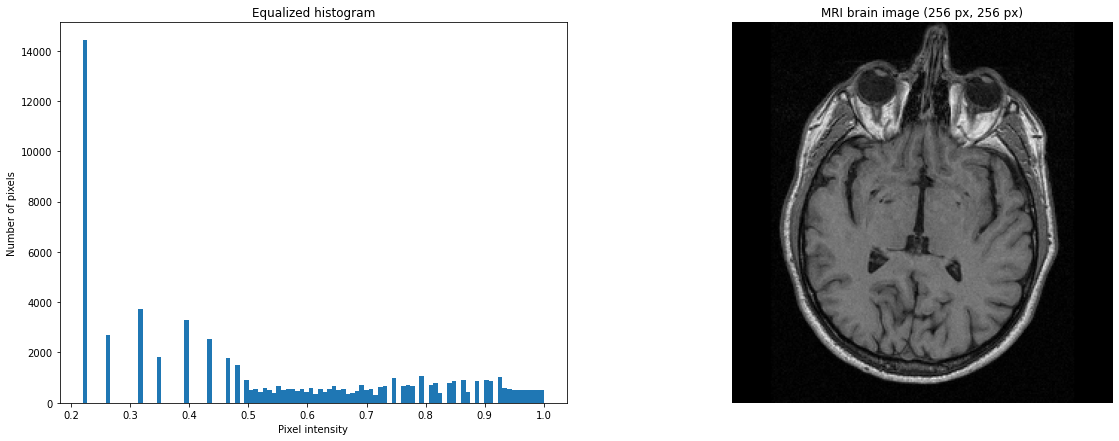

In [20]:
# Normalize histogram to enhance contrast
brain_im_eq = exposure.equalize_hist(brain_im)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20,7))
ax1.hist(brain_im_eq.ravel(), bins=100)
ax1.set_xlabel('Pixel intensity')
ax1.set_ylabel('Number of pixels')
ax1.set_title('Equalized histogram')

ax2.imshow(brain_im, cmap='gray')
ax2.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax2.axis('off')
plt.show()

Then we use a hand-picked seed that is clearly part of the brain, and we use region growing to find the connex region around it that match a homogeneity criterion. This is done by maintaining a queue of pixels "at the edge" of the growing region whose neighbours needs to be examined.

The homogeneity criterion uses two threshold: a local threshold between adjacent pixels, to avoid crossing sharp edges, and a global threshold used to avoid crossing smooth transitions by comparing the intensity of the considered pixel with the intensity of the seed.

Number of pixels in the detected region: 17230


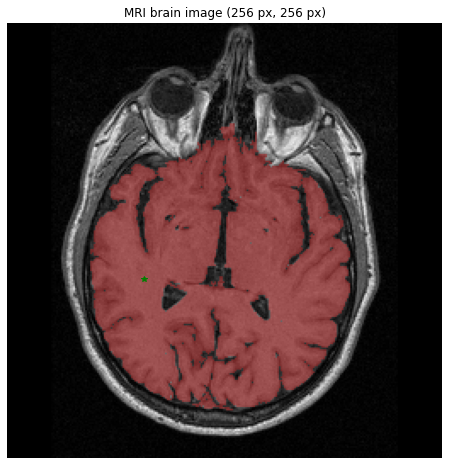

In [21]:


# Seed the detection algorithm with a point that is obviously part of the brain
seed = (150, 80)

global_threshold = 0.35
local_threshold = 0.10

# Initialize the brain region
region = np.zeros((im_h, im_w))
region[seed] = 1

# Pixels that are at the edge of the growing region
edges = deque((seed,))

# As long as edges are available
while edges:
    x, y = edges.pop()
    for dx, dy in ((1, 0), (0, 1), (-1, 0), (0, -1)):
        candidate = (x + dx, y + dy)
        if (0 <= candidate[0] < im_h and 0 <= candidate[1] < im_w
            and not region[candidate] 
            and abs(brain_im_eq[seed] - brain_im_eq[candidate]) < global_threshold 
            and abs(brain_im_eq[x, y] - brain_im_eq[candidate]) < local_threshold):
            region[candidate] = 1
            edges.append(candidate)
    
fig, ax = plt.subplots(figsize=(8,8))
cmap = matplotlib.colors.ListedColormap(['red'])
ax.imshow(brain_im, cmap='gray')
ax.imshow(np.ones(region.shape), alpha=region*0.3, cmap=cmap)
ax.plot(seed[1], seed[0], marker='*', color='green')
ax.set_title('MRI brain image ({} px, {} px)'.format(im_h, im_w))
ax.axis('off')

print(f"Number of pixels in the detected region: {int(region.sum())}")

This method is quite simple, computationally inexpensive, and yields relatively good results. However, it needs a seed that is in the region to select in order to work. This can be problematic if the position of the object to detect vary significantly across the images. It also needs a calibration of the thresholds, and it is therefore sensitive to exposition variations.

### 1.3 Contour detection (5pts)

The goal of this part is to detect the contours, from this we will be able to create a binary image which will highlight the skull and will enable us to count the pixels inside the skull.

In this part we will be using the **Sobel filter for edge detection**. Note that a number of other filters could be used 

1 - 
As a first step we will apply a Gaussian filter which helps with edge detection by reducing the amount of noise and speckles in the image.

2-
We then use a sobel filter and apply it on the image. No libraries were used but results were compared to open-cv filter for testing 

3- 
Following the filter, we plot the histogram and set a threshold to get binary values

4-
We then use a morphological operator called closing that enables us to fill in holes and smoothen the contours. Note that information is "lost" 

5-
The contour is found using Open-cv "find contours" function and its area is computer once again with open-cv




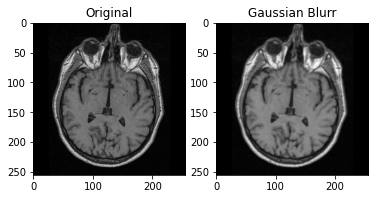

In [22]:
# Reduce noise in image
brain_im_blurr = cv2.GaussianBlur(brain_im, (3,3),0)

fig, (ax1, ax2) = plt.subplots(1,2, figsize=(6, 6))
ax1.set_title('Original')
ax1.imshow(brain_im, cmap = "gray")
ax2.set_title('Gaussian Blurr')
ax2.imshow(brain_im_blurr, cmap='gray')
plt.show()

In [23]:
# Implement Sobel edge detection filter

sobel_x = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
sobel_y = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])

# Size original image
[rows, columns] = np.shape(brain_im_blurr)

# Initialize sobel filtered image to zero
sobel_brain_img = np.zeros(shape=(rows, columns))  

# Apply on image with kernel of size 3
for i in range(rows - 2):
    for j in range(columns - 2):
        # x direction
        brain_img_x = np.sum(np.multiply(sobel_x, brain_im_blurr[i:i + 3, j:j + 3]))  
        # y direction
        brain_img_y = np.sum(np.multiply(sobel_y, brain_im_blurr[i:i + 3, j:j + 3]))  
        
        sobel_brain_img[i + 1, j + 1] = np.sqrt(brain_img_x ** 2 + brain_img_y ** 2)  

The last line above is used in order to combine the horizontal and vertical convolutions.
These are two ways in which they can be combined; the first one is used. (Source)[https://docs.opencv.org/3.4/d2/d2c/tutorial_sobel_derivatives.html]
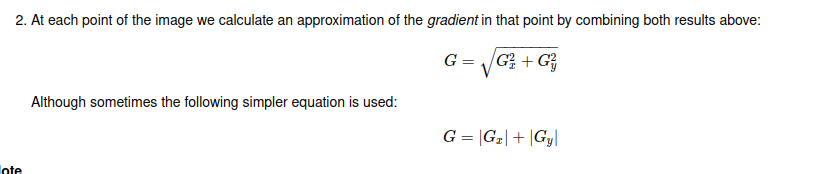

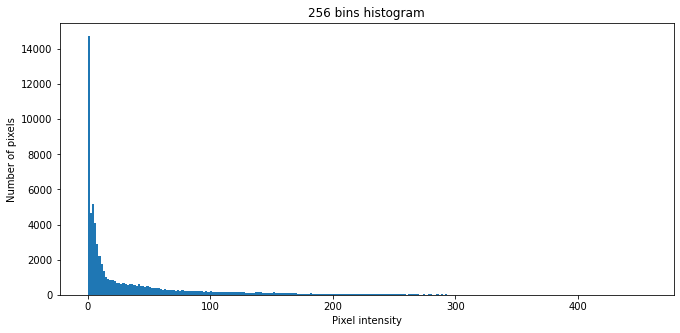

In [24]:
# Plot diagram to estimate threshold
nb_bins = 256
# Display histogram
plt.figure(figsize=(11, 5))
plt.hist(sobel_brain_img.ravel(), bins=nb_bins)
plt.xlabel('Pixel intensity')
plt.ylabel('Number of pixels')
plt.title('256 bins histogram')

plt.show()

In [25]:
# Set a threshold
pixel_thresh=65

_, brain_img_thresh = cv2.threshold(sobel_brain_img, pixel_thresh, 255, 0)

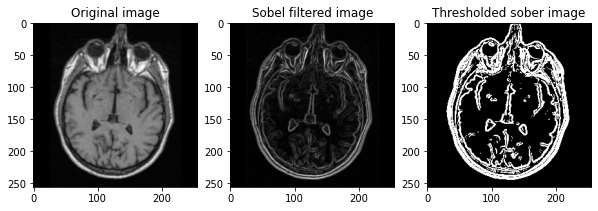

In [26]:
fig, ax = plt.subplots(1, 3, figsize=(10, 10))

ax[0].set_title("Original image")
ax[1].set_title("Sobel filtered image")
ax[2].set_title("Thresholded sober image")
ax[0].imshow(brain_im_blurr, cmap = "gray")
ax[1].imshow(sobel_brain_img, cmap="gray")
ax[2].imshow(brain_img_thresh, cmap="gray")


In [27]:
# We use the closing morphological operator and pick the kernel size by test and trial
closing_kernel = np.ones((3,3))
brain_img_closed = cv2.morphologyEx(brain_img_thresh, cv2.MORPH_CLOSE, closing_kernel)

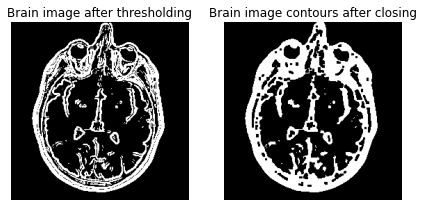

In [28]:
fig, ax = plt.subplots(1, 2, figsize=(7, 7))
ax[0].imshow(brain_img_thresh, cmap='gray')
ax[0].set_title('Brain image after thresholding')
ax[0].axis('off')
ax[1].imshow(brain_img_closed, cmap='gray')
ax[1].set_title('Brain image contours after closing')
ax[1].axis('off')
plt.show()

In [29]:
# From float to int
brain_img_closed_int = np.uint8(brain_img_closed)
brain_contours, hierarchy = cv2.findContours(brain_img_closed_int, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

Number of pixels in the detected region: 16529.0


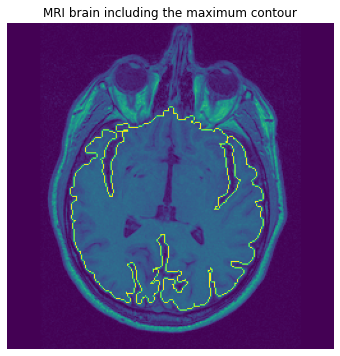

In [32]:
# Compute the areas of the found contour
# Store all areas
areas = []
for i in range(1,len(brain_contours)):
    areas.append(cv2.contourArea(brain_contours[i]))  

# Compute contour area for the largest computed area 
max_area_id = np.argmax(areas) + 1


brain_img_copy = np.copy(brain_im)

# Contoured brain
brain_contoured = cv2.drawContours(brain_img_copy, brain_contours, max_area_id, (255,255,255), 1)
fig, ax = plt.subplots(1, 1, figsize=(6, 6))
ax.imshow(brain_contoured)
ax.set_title("MRI brain including the maximum contour")

print(f"Number of pixels in the detected region: {np.max(areas)}")
ax.axis("off")
plt.show()

The result is comparable to the one with region growing (12730) though does appear less precise. In this case we need to set a threshold manually but also test several values for the closing kernel size.

### 1.4 Additional method (5pts)

In [ ]:
# Add your implementation and discussion

---
## Part 2: Shape/color segmentation

You will find hereafter three pictures taken under three different illuminations, containing some shapes with different
colors. We ask you to create a routine to:

1. Count the number of shapes of each color (5pts).
2. Compute the total area (in pixels) of each color (5pts).

Please note that one specific challenge is to be robust to illumination changes. Therefore some kind of intensity
normalization should probably be used.

hint: RGB color space might not be optimal. Consider using HSV or LAB color space.

### 2.1 Visualization

In [ ]:
# Load images
im_names = ['arena-shapes-01', 'arena-shapes-02', 'arena-shapes-03']
filenames = [os.path.join(data_path, name) + '.png' for name in im_names]
ic = skimage.io.imread_collection(filenames)
images = skimage.io.concatenate_images(ic)
print('Number of images: ', images.shape[0])
print('Image size: {}, {} '.format(images.shape[1], images.shape[2]))
print('Number of color channels: ', images.shape[-1])

In [ ]:
# Plot images
fig, axes = plt.subplots(1, 3, figsize=(12, 12))
for ax, im, nm in zip(axes.ravel(), images, im_names):
    ax.imshow(im)
    ax.axis('off')
    ax.set_title(nm)
plt.show()

### 2.2 Number of shapes of each color (5 pts)

In [ ]:
# Add your implementation and discussion

### 2.3 Total area (in pixels) of each color (5 pts)

In [ ]:
# Add your implementation and discussion